In [1]:
import flow_matching
import numpy as np
import torch
import matplotlib.pyplot as plt
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper
import time
from torch import nn, Tensor
import numba as nb
# fix np, torch random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

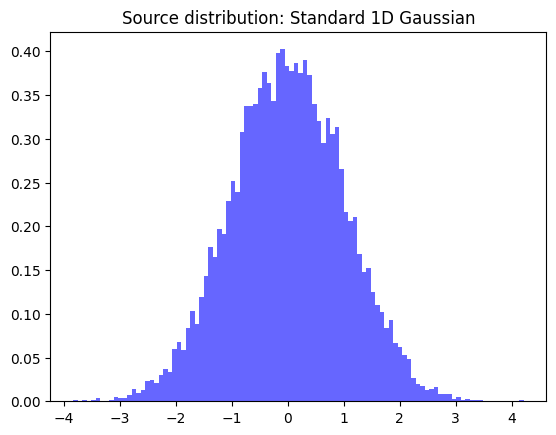

In [2]:
# Source distribution: Standard 1D Gaussian
source_dist = torch.distributions.Normal(0.0, 1.0)
plt.hist(source_dist.sample((10000,)).numpy(), bins=100, density=True, alpha=0.6, color='b')
plt.title("Source distribution: Standard 1D Gaussian")
plt.show()

In [7]:
realistic_dataset = np.load("data.npy")
dphi = realistic_dataset[:, 6]  # Assuming 7th column is the target variable
dphi_tensor = torch.tensor(dphi, dtype=torch.float32)

x_0 shape: torch.Size([379678, 1]) tensor([[-1.1723],
        [ 0.4068],
        [-0.6165],
        [-0.6137],
        [ 1.0867]])
x_t shape: torch.Size([379678, 1]) tensor([[ 2.4555],
        [ 0.9592],
        [-0.6242],
        [ 0.1004],
        [ 1.4114]])
x_1 shape: torch.Size([379678, 1]) tensor([[ 2.6025],
        [ 1.1028],
        [-1.3748],
        [ 0.4531],
        [ 2.5369]])
reconstruction test for x_0:
x_0_reconstructed shape: torch.Size([379678, 1]) tensor([[-1.1723],
        [ 0.4068],
        [-0.6165],
        [-0.6137],
        [ 1.0867]])
Difference between original and reconstructed x_0: tensor(0.0073)
velocity field test:
Computing velocity field from library...
torch.Size([379678, 1]) tensor([[ 3.7748],
        [ 0.6960],
        [-0.7582],
        [ 1.0668],
        [ 1.4501]])
Computing velocity field from analytic formula...
manual_vf shape: torch.Size([379678, 1]) tensor([[ 3.7748],
        [ 0.6960],
        [-0.7582],
        [ 1.0668],
        [ 1.4501]]

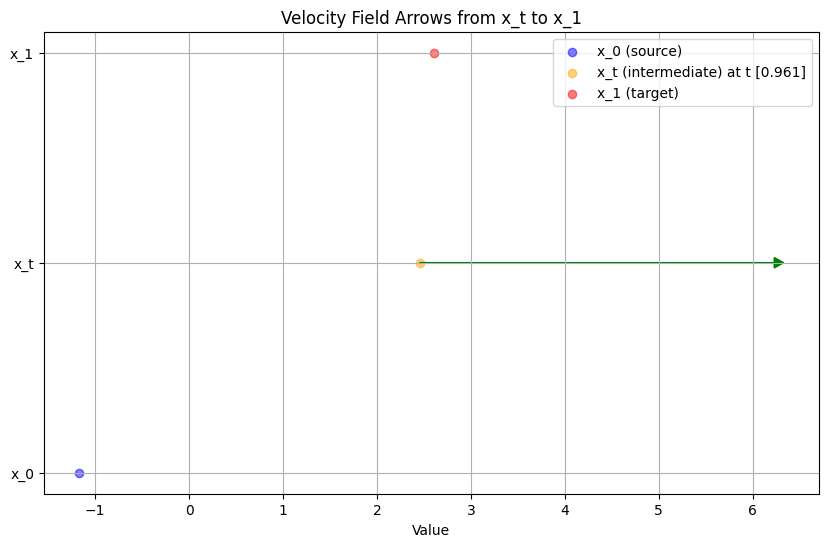

In [4]:
# first let's check x_0, x_t and x_1 from the library

path = AffineProbPath(scheduler=CondOTScheduler())
# Sample data
x_1 = dphi_tensor.unsqueeze(1)
x_0 = source_dist.sample((x_1.shape[0],)).unsqueeze(1)

# Sample time uniformly
t = torch.rand(x_1.shape[0])
    
# Sample probability path
path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

print("x_0 shape:", x_0.shape, x_0[:5])
print("x_t shape:", path_sample.x_t.shape, path_sample.x_t[:5])
print("x_1 shape:", x_1.shape, x_1[:5])

# now let's try to recover x_0 knowing x_1 and x_t
# x_t = (1 - t) * x_0 + t * x_1  =>  x_0 = (x_t - t * x_1) / (1 - t)
print("reconstruction test for x_0:")
x_0_reconstructed = (path_sample.x_t - t.unsqueeze(1) * x_1) / ((1 - t).unsqueeze(1)+1e-8)
print("x_0_reconstructed shape:", x_0_reconstructed.shape, x_0_reconstructed[:5])
print("Difference between original and reconstructed x_0:", torch.abs(x_0 - x_0_reconstructed).max())

# now let's check the path vf comparing with an analytic formula 
print("velocity field test:")
print("Computing velocity field from library...")
print(path_sample.dx_t.shape, path_sample.dx_t[:5])
print("Computing velocity field from analytic formula...")
manual_vf = (x_1 - path_sample.x_t) / ((1 - t).unsqueeze(1)+1e-8)
print("manual_vf shape:", manual_vf.shape, manual_vf[:5])

# now plot a scatterplot for the first 3 points doing x_0, x_t, x_1 and the vf as arrows
n_points_to_plot = 1
plt.figure(figsize=(10, 6))
plt.scatter(x_0.numpy()[:n_points_to_plot], np.zeros_like(x_0.numpy()[:n_points_to_plot]), color='blue', label='x_0 (source)', alpha=0.5)
plt.scatter(path_sample.x_t.numpy()[:n_points_to_plot], np.ones_like(path_sample.x_t.numpy()[:n_points_to_plot]), color='orange', label=f'x_t (intermediate) at t {t[:n_points_to_plot].numpy().round(3)}', alpha=0.5)
plt.scatter(x_1.numpy()[:n_points_to_plot], 2 * np.ones_like(x_1.numpy()[:n_points_to_plot]), color='red', label='x_1 (target)', alpha=0.5)   
for i in range(n_points_to_plot):
    plt.arrow(path_sample.x_t[i].item(), 1, path_sample.dx_t[i].item(), 0, head_width=0.05, head_length=0.1, fc='green', ec='green')
plt.yticks([0, 1, 2], ['x_0', 'x_t', 'x_1'])
plt.xlabel('Value')
plt.title('Velocity Field Arrows from x_t to x_1')
plt.legend()
plt.grid()
plt.show()

In [5]:
import numba as nb

@nb.njit(parallel=True, fastmath=True)
def compute_exact_velocity_numba(x_t, t, data_points):
    """
    Compute exact velocity field using Numba
    
    """
    batch_size = x_t.shape[0]
    n_data = data_points.shape[0]
    velocities = np.zeros((batch_size, 1), dtype=np.float32)
    
    sqrt_2pi = np.sqrt(2 * np.pi)
    
    # Parallel loop over samples
    for i in nb.prange(batch_size):
        xt = x_t[i, 0]
        ti = t[i]
        
        velocity_sum = 0.0
        weight_sum = 0.0
        std_factor = 1 / (1 - ti + 1e-8)
        
        # Vectorized inner loop over datapoints
        for j in range(n_data):
            manual_vf = (data_points[j] - xt) * std_factor
            manual_x0 = (xt - ti * data_points[j]) * std_factor
            weight = np.exp(-0.5 * ((manual_x0) ** 2)) / sqrt_2pi
            velocity_sum += manual_vf * weight
            weight_sum += weight
        
        velocity_sum /= weight_sum + 1e-8
        velocities[i, 0] = velocity_sum
    
    return velocities

In [6]:
# for the same example point above, let's compute the velocity field with numba
x_t_np = path_sample.x_t.numpy()[:10]
t_np = t.numpy()[:10]
data_points_np = dphi_tensor.numpy()
start_time = time.time()
vf_numba = compute_exact_velocity_numba(x_t_np, t_np, data_points_np)
end_time = time.time()

print("Numba computed velocity field shape:", vf_numba.shape, vf_numba[:5])



Numba computed velocity field shape: (10, 1) [[2.5724928 ]
 [1.2158902 ]
 [0.6032163 ]
 [0.1743624 ]
 [0.12326227]]


In [ ]:

n_samples = 50000
# solve through Euler using all data_points for velocity calculation
data_points_tensor = dphi_tensor.to('cpu')
T_fine = torch.linspace(0, 1, 100).to('cpu')
x_init_exact = source_dist.sample((n_samples,)).unsqueeze(1).to('cpu')
x_t = x_init_exact.clone()
for i in range(1, len(T_fine)):
    t_prev = T_fine[i-1]
    t_curr = T_fine[i]
    dt = t_curr - t_prev
    
    t_batch = t_prev.expand(n_samples).to('cpu')
    v_exact = compute_exact_velocity_numba(x_t.numpy(), t_batch.numpy(), data_points_tensor.numpy())
    v_exact = torch.tensor(v_exact, dtype=torch.float32).to('cpu')
    
    x_t = x_t + v_exact * dt
sol_exact = x_t.cpu().numpy().squeeze()
print(f"Generated exact trajectories shape: {sol_exact.shape}")

# plot final distribution from exact integration and compare with target dataset
plt.hist(dphi, bins=100, density=True, alpha=0.6, color='b', label='Target dataset')
plt.hist(sol_exact, bins=100, density=True, alpha=0.6, color='g', label='Exact integration')
plt.title("Final distribution from exact integration")
plt.legend()
plt.show()

In [4]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 1, time_dim: int = 1, hidden_dim: int = 128, num_layers: int = 4):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        self.layer_norm = nn.LayerNorm(input_dim)

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    Swish(),
                ) for _ in range(num_layers - 2)
            ],
            nn.Linear(hidden_dim, input_dim),
        )
    
    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        # x = self.layer_norm(x)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

In [12]:
vf = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to('cuda')
nn_model = torch.load("experiment_4_dphi_model.pth")
vf.load_state_dict(nn_model)
vf.eval()

MLP(
  (layer_norm): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
  (main): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Swish()
    (2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Swish()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Swish()
    )
    (4): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Swish()
    )
    (5): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Swish()
    )
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Generated exact trajectories from uniform source shape: (100000,)


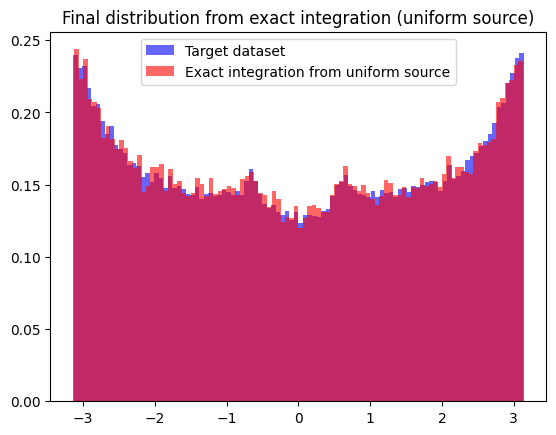

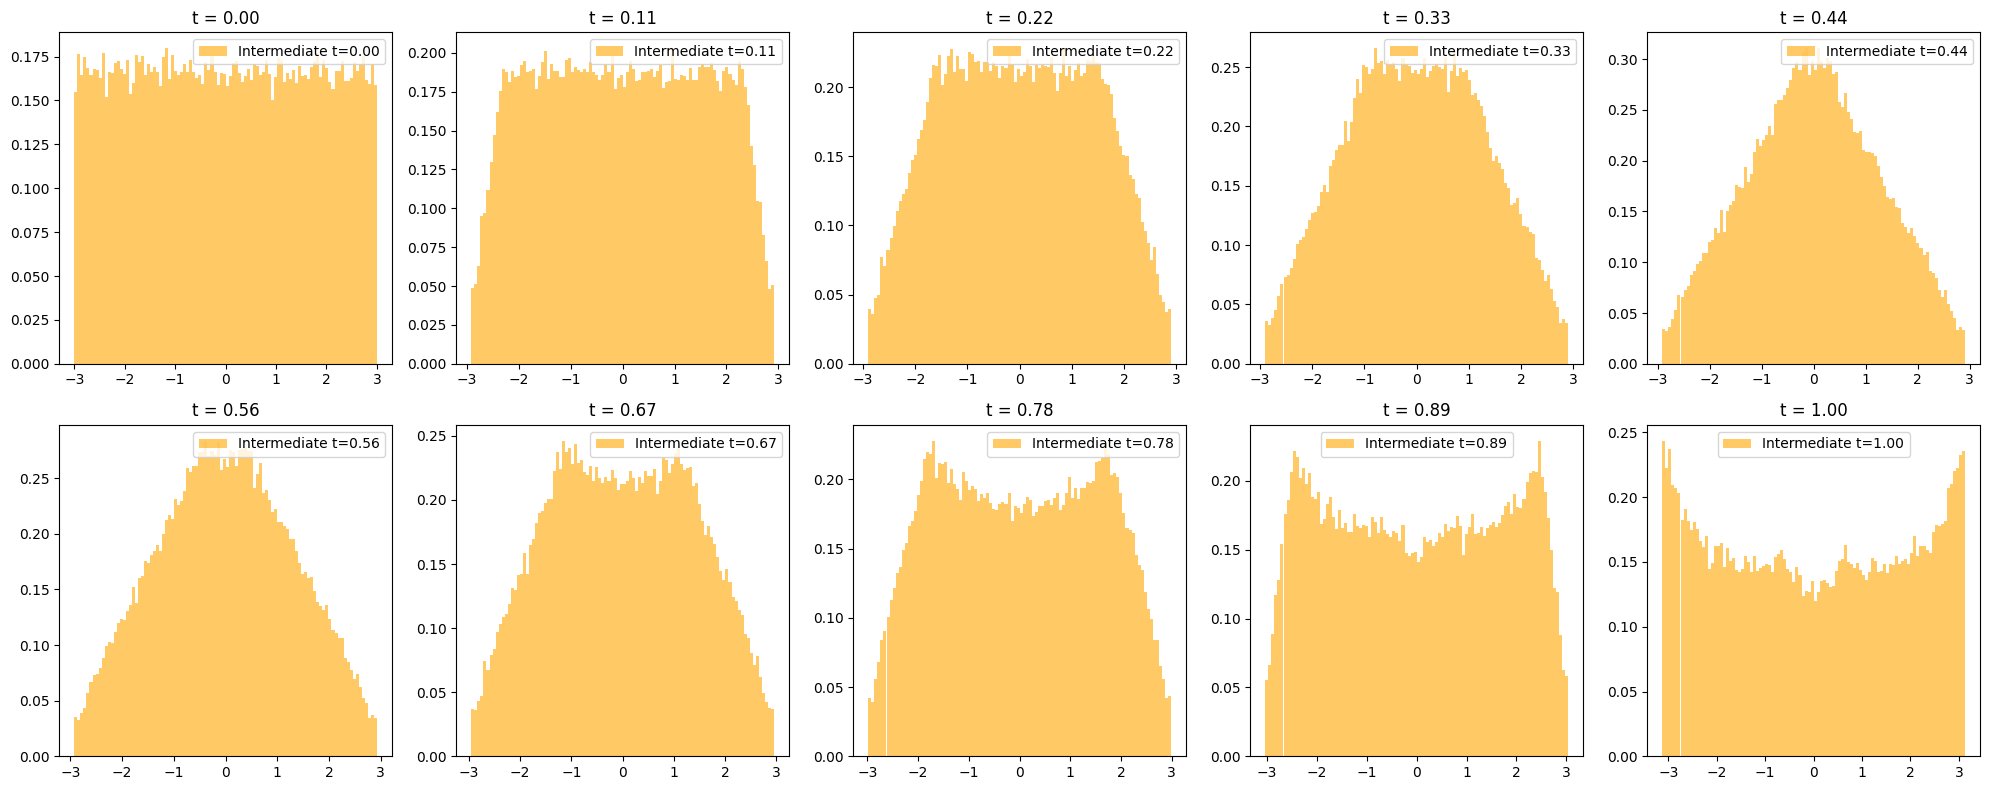

In [13]:
#new source, uniform between -3 and 3
n_samples = 100000
new_source_samples = np.random.uniform(-3, 3, size=(n_samples, 1)).astype(np.float64)

# new velocity calculation with numba knowing that the density is uniform between -3 and 3
@nb.njit(parallel=True, fastmath=True)
def compute_exact_velocity_numba_uniform(x_t, t, data_points, source_min, source_max):
    """
    Compute exact velocity field using Numba for uniform distribution between data_min and data_max
    
    """
    batch_size = x_t.shape[0]
    n_data = data_points.shape[0]
    velocities = np.zeros((batch_size, 1), dtype=np.float64)
    
    sqrt_2pi = np.sqrt(2 * np.pi)
    uniform_density = 1.0 / (source_max - source_min)
    
    # Parallel loop over samples
    for i in nb.prange(batch_size):
        xt = x_t[i, 0]
        ti = t[i]
        
        velocity_sum = 0.0
        weight_sum = 0.0
        std_factor = 1 / (1 - ti + 1e-16)
        
        # Vectorized inner loop over datapoints
        for j in range(n_data):
            manual_vf = (data_points[j] - xt) * std_factor
            manual_x0 = (xt - ti * data_points[j]) * std_factor
            # Since the density is uniform, we can use a constant weight
            weight = uniform_density if (source_min <= manual_x0 <= source_max) else 0.0
            velocity_sum += manual_vf * weight
            weight_sum += weight
        
        velocity_sum /= weight_sum 
        velocities[i, 0] = velocity_sum
    
    return velocities

# solve
data_min = -3
data_max = 3
data_points_tensor = dphi_tensor.to('cpu')
T_fine = torch.linspace(0, 1, 100).to('cpu')
x_init_exact = torch.tensor(new_source_samples, dtype=torch.float64).to('cpu')
x_t = x_init_exact.clone()
x_intermediate = [x_t.clone()]
vf_intermediate = []
vf_nn_intermediate = []
diff_vf_intermediate = []
for i in range(1, len(T_fine)):
    t_prev = T_fine[i-1]
    t_curr = T_fine[i]
    dt = t_curr - t_prev
    
    t_batch = t_prev.expand(n_samples).to('cpu')
    v_exact = compute_exact_velocity_numba_uniform(x_t.numpy(), t_batch.numpy(), data_points_tensor.numpy(), data_min, data_max)
    v_exact = torch.tensor(v_exact, dtype=torch.float64).to('cpu')
    with torch.no_grad():
        vf_nn = vf(x_t.float().to('cuda'), t_batch.float().to('cuda')).double().to('cpu')
        torch.cuda.empty_cache()
    
    x_t = x_t + v_exact * dt
    x_intermediate.append(x_t.clone())
    vf_intermediate.append(v_exact.clone())
    vf_nn_intermediate.append(vf_nn.clone())
    diff_vf_intermediate.append((v_exact - vf_nn).abs().mean().item())
    
    
sol_exact_uniform = x_t.cpu().numpy().squeeze()
print(f"Generated exact trajectories from uniform source shape: {sol_exact_uniform.shape}")

# plot final distribution from exact integration and compare with target dataset
plt.hist(dphi, bins=100, density=True, alpha=0.6, color='b', label='Target dataset')
plt.hist(sol_exact_uniform, bins=100, density=True, alpha=0.6, color='r', label='Exact integration from uniform source')
plt.title("Final distribution from exact integration (uniform source)")
plt.legend()
plt.show()

# plot intermediate distributions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T_fine)-1, 10, dtype=int)
for idx, ax in zip(time_indices, axes):
    #ax.hist(dphi, bins=100, density=True, alpha=0.6, color='b', label='Target dataset')
    intermediate_sol = x_intermediate[idx].cpu().numpy().squeeze()
    ax.hist(intermediate_sol, bins=100, density=True, alpha=0.6, color='orange', label=f'Intermediate t={T_fine[idx]:.2f}')
    ax.set_title(f"t = {T_fine[idx]:.2f}")
    ax.legend()
plt.tight_layout()
plt.show()

In [8]:
# save x_intermediate to a npy file
np.save('x_intermediate.npy', x_intermediate)

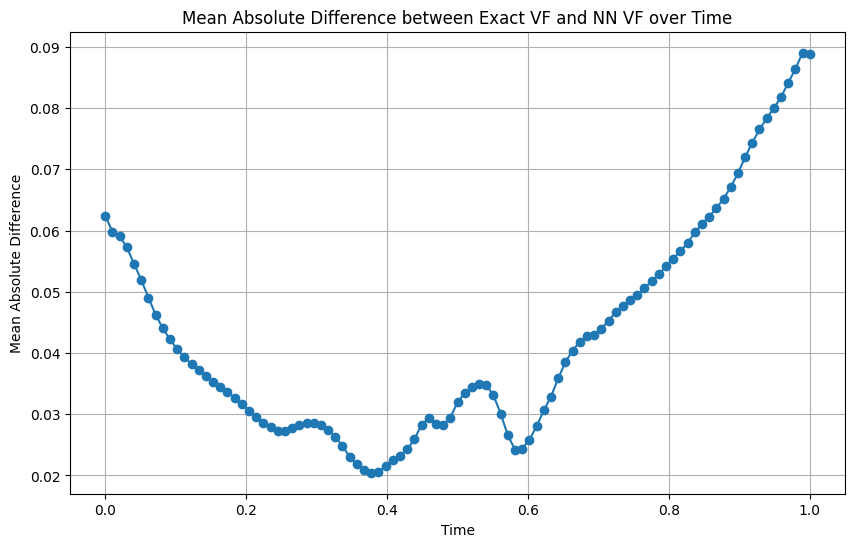

In [14]:
# now let's plot the vf difference over time
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, len(diff_vf_intermediate)), diff_vf_intermediate, marker='o')
plt.title("Mean Absolute Difference between Exact VF and NN VF over Time")
plt.xlabel("Time")
plt.ylabel("Mean Absolute Difference")
plt.grid()
plt.show()

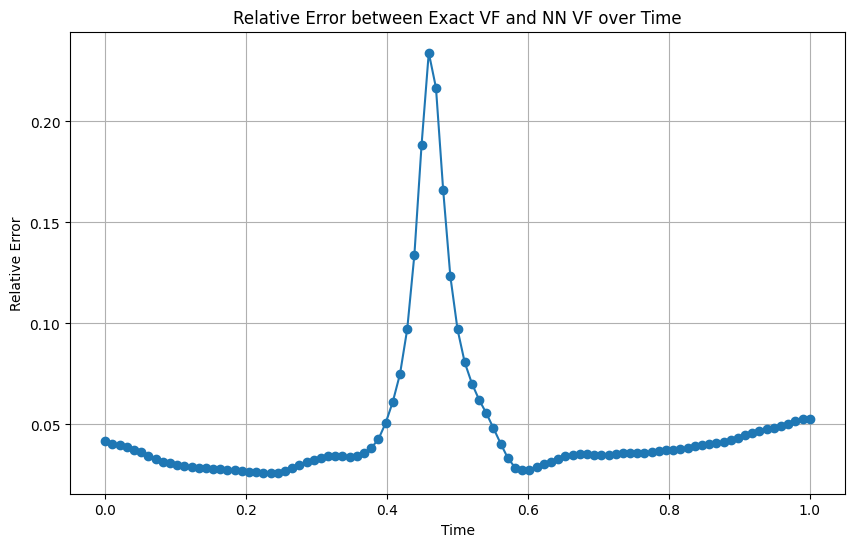

In [15]:
# let's plot the relative error (so mean absolute difference divided by sum of vf)
relative_errors = []
for exact_vf, nn_vf in zip(vf_intermediate, vf_nn_intermediate):
    relative_error = (exact_vf - nn_vf).abs().mean().item() / (exact_vf.abs().mean().item() + 1e-8)
    relative_errors.append(relative_error)
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, len(relative_errors)), relative_errors, marker='o')
plt.title("Relative Error between Exact VF and NN VF over Time")
plt.xlabel("Time")
plt.ylabel("Relative Error")
plt.grid()
plt.show()

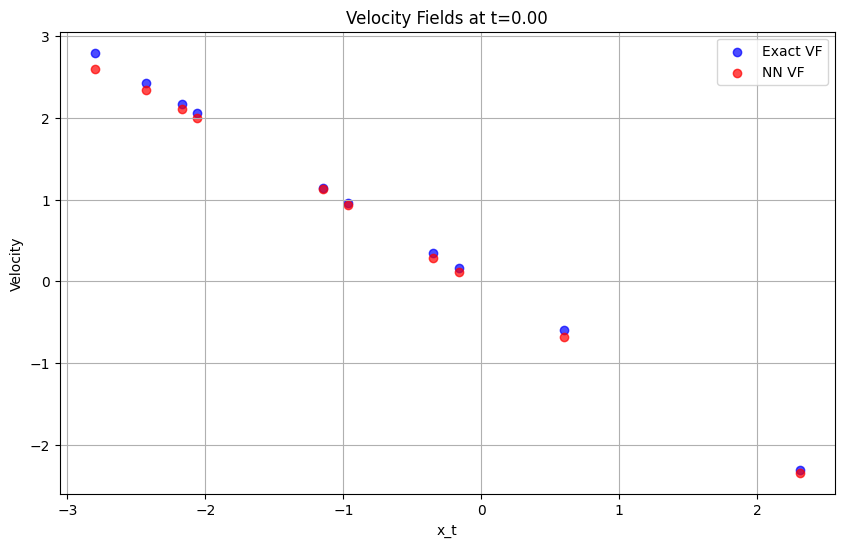

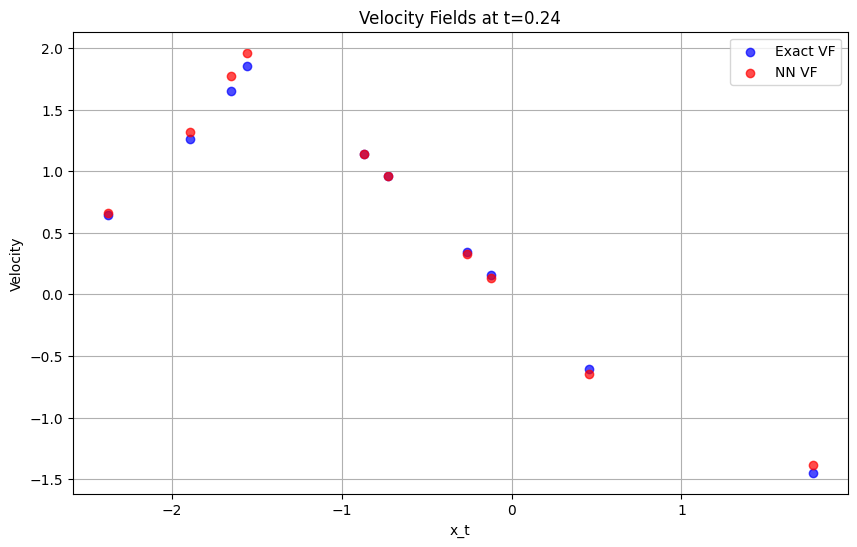

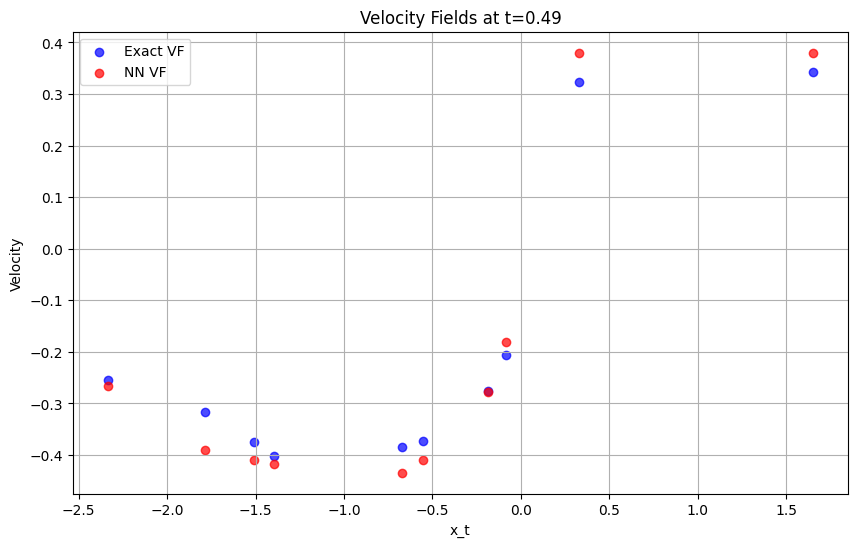

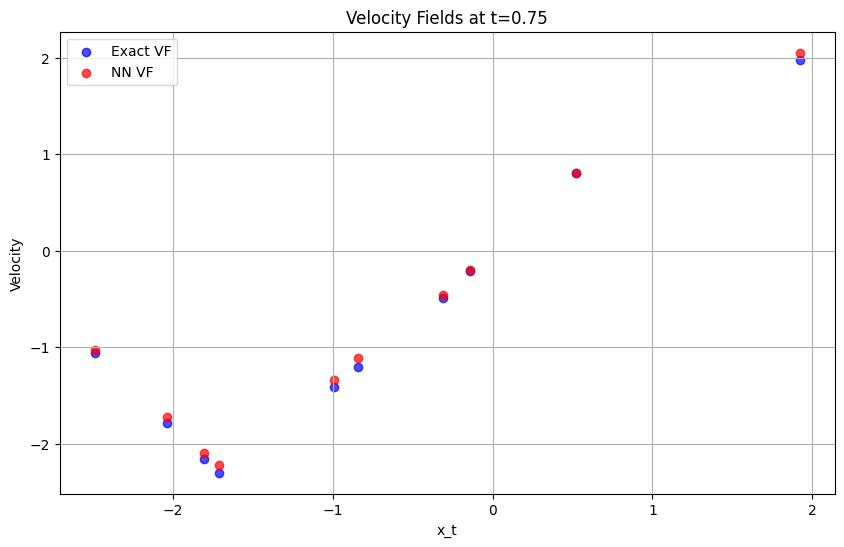

IndexError: list index out of range

In [16]:
# let's plot in 2d the velocity fields at different time steps and at different x_t locations
n_points_to_plot = 10
time_indices = [0, 24, 49, 74, 99]  # Corresponding to t=0.0, 0.25, 0.5, 0.75, 1.0

for time_idx in time_indices:
    x_t_step = x_intermediate[time_idx].cpu().numpy()
    vf_exact_step = vf_intermediate[time_idx].cpu().numpy()
    vf_nn_step = vf_nn_intermediate[time_idx].cpu().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_t_step[:n_points_to_plot], vf_exact_step[:n_points_to_plot], color='blue', label='Exact VF', alpha=0.7)
    plt.scatter(x_t_step[:n_points_to_plot], vf_nn_step[:n_points_to_plot], color='red', label='NN VF', alpha=0.7)
    plt.title(f"Velocity Fields at t={T_fine[time_idx]:.2f}")
    plt.xlabel("x_t")
    plt.ylabel("Velocity")
    plt.legend()
    plt.grid()
    plt.show()